In [1]:
# To use TF 2.0 (on EC2 instance running Deep Learning AMI):
# source activate tensorflow_p36
# pip uninstall tensorflow-gpu
# pip install tensorflow-gpu==2.0.0-alpha0

# But then later decided wanted even newer GPU stuff and "in that conda env, ran:
# pip uninstall tensorflow-gpu
# pip install --upgrade pip
# pip install wrapt --ignore-installed # ran this because had an error
# pip install  tf-nightly-gpu-2.0-preview

# Result: Successfully installed tf-nightly-gpu-2.0-preview-2.0.0.dev20190601

In [2]:
import os
from datetime import datetime
import numpy as np
import tensorflow as tf

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn') # pretty matplotlib plots
plt.rcParams["axes.grid"] = False # don't show grid lines on plots by default
plt.rcParams['figure.figsize'] = (12, 16) # increase size of subplots

In [4]:
from packaging import version

print("TensorFlow version: ", tf.__version__) # make sure >= 2.0.0-dev20190605
assert version.parse(tf.__version__).release[0] >= 2, "This notebook requires TensorFlow 2.0 or above."


TensorFlow version:  2.0.0-dev20190605


In [5]:
import cs230_project_utilities as utils

In [6]:
# GPU usage logging (TF 2.0+)

tf.config.set_soft_device_placement(True)
tf.debugging.set_log_device_placement(False)

# Load dataset as TFRecords 

In [ ]:
# Sync from remote storage in s3
# aws s3 sync s3://cs230-automap/data/fastmri/tfrecords cs230/data/fastmri/tfrecords

In [7]:
dev_locations = '/home/ubuntu/cs230/data/fastmri/tfrecords/singlecoil_dev/*.tfrecord'
test_locations = '/home/ubuntu/cs230/data/fastmri/tfrecords/singlecoil_test/*.tfrecord'
train_locations = '/home/ubuntu/cs230/data/fastmri/tfrecords/singlecoil_train/*.tfrecord'

In [8]:
# Use tf.data.Datasets to preprocess and iterate data efficiently

dev_dataset = utils.fastmri.load_dataset(dev_locations,
                                         batch_size=32,
                                         shuffle_buffer_size=1,
                                         load_original_reconstruction=False,
                                         include_all_parsed_features=False,
                                         ignore_errors=True,
                                         perform_data_augmentation=False)

test_dataset = utils.fastmri.load_dataset(test_locations,
                                          batch_size=32,
                                          shuffle_buffer_size=1,
                                          load_original_reconstruction=False,
                                          include_all_parsed_features=False,
                                          ignore_errors=True,
                                          perform_data_augmentation=False)

train_dataset = utils.fastmri.load_dataset(train_locations,
                                           batch_size=32,
                                           shuffle_buffer_size=1024,
                                           load_original_reconstruction=False,
                                           include_all_parsed_features=False,
                                           ignore_errors=True,
                                           perform_data_augmentation=False)

Loading dataset... Shuffle items? True. Shuffle buffer: 1024
Loading dataset... Shuffle items? True. Shuffle buffer: 1024
Loading dataset... Shuffle items? True. Shuffle buffer: 1024


# Validate dataset
Make sure target reconstruction is the same as reconstruction computed from input.

In [9]:
# First batch of each dataset to be used in plotting images periodically to tensorboard

first_test_batch = next(iter(test_dataset))
first_dev_batch = next(iter(dev_dataset))
first_train_batch = next(iter(train_dataset))

In [10]:
first_test_batch[0].shape

TensorShape([32, 128, 128, 2])

In [11]:
fft, target_image = first_test_batch[0][0].numpy().squeeze(), first_test_batch[1][0].numpy().squeeze()
fft = utils.fastmri._combine_two_channels_of_complex_tensor(fft).numpy()

# Compute image from input `fft`
image_from_fft = tf.abs(utils.signal_processing.tf_ifft2d(fft)).numpy().squeeze()

# Compare target image to reconstruction from input `fft`
np.allclose(image_from_fft, target_image, atol=1e-6), utils.signal_processing.mean_square_error(image_from_fft, target_image)

(True, 2.3838604e-14)

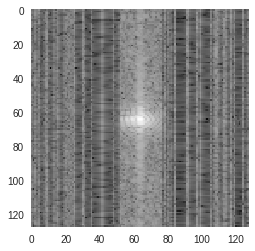

In [12]:
utils.plot.imshowfft(fft)

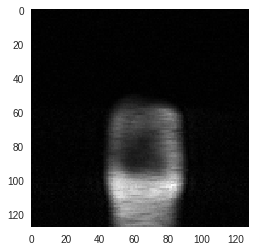

In [13]:
utils.plot.imshowgray(target_image)

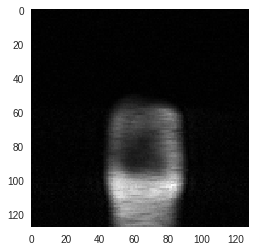

In [14]:
utils.plot.imshowgray(image_from_fft)

/home/ubuntu/cs230/code/MRI_reconstruction_example/cs230_project_utilities/plot.py:13: RuntimeWarning: divide by zero encountered in log10
  imshowgray(20 * np.log10(np.abs(fft)))


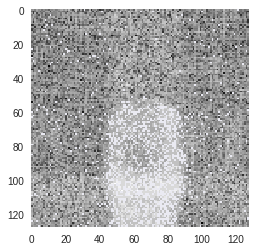

In [15]:
utils.plot.imshowfft(np.square(target_image - image_from_fft))

# Model

In [65]:
# A metric to use during training
def mean_PSNR(y_true, y_pred):
    max_value = 256.0
    MSE = tf.reduce_mean(tf.square(y_true - y_pred), axis=[1, 2, 3])
    PSNR = 10 * tf.math.log(tf.divide(max_value ** 2, MSE)) / tf.math.log(tf.constant(10, dtype=y_pred.dtype))
    mean = tf.reduce_mean(PSNR)
    return mean

In [17]:
def load_uncompiled_automap_model():

    N = 128
    X = tf.keras.layers.Input(shape=(N, N, 2))

    # Paper says 1% multiplicative gaussian noise (this multiplies by 1-centered gaussian
    # having stddev = sqrt(rate / (1 - rate)) (here, 0.00032...)
    # noisy_X = tf.keras.layers.GaussianDropout(rate=1e-7)(X) # spatial dimension: 256
    # Note: (we could corrupt when training with cifar, but maybe not other dataset?)

    ds_flat = tf.keras.layers.Flatten()(X)

    fc1 = tf.keras.layers.Dense(64 ** 2, activation='tanh')(ds_flat) # closer to original paper is: 128 ** 2
    fc1 = tf.keras.layers.Dropout(0.05)(fc1)
    fc2 = tf.keras.layers.Dense(128 ** 2, activation='tanh')(fc1)

    fc_output = tf.keras.layers.Reshape([128, 128, 1])(fc2)

    conv1 = tf.keras.layers.Conv2D(64, (5, 5), strides=(1, 1), activation='relu', padding='same')(fc_output)
    
    # L1 regularization to encourage sparsity
    conv2 = tf.keras.layers.Conv2D(64, (5, 5), strides=(1, 1), activation='relu', padding='same',
                                   activity_regularizer=tf.keras.regularizers.l1(1e-4))(conv1)

    Y_pred = tf.keras.layers.Conv2DTranspose(1, (7, 7), strides=1, activation='relu', padding='same')(conv2) # upsample to spatial dimension 256

    model = tf.keras.Model(inputs=X, outputs=Y_pred)

    return model

In [62]:
def load_compiled_automap_model():
    
    initial_learning_rate = 1e-4
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=10000,
        decay_rate=0.96,
        staircase=True)

    multi_gpu = False
    if multi_gpu:
        # Distribute training across GPUs (each GPU receives identical updates to weights but different batches w/
        # mirrored strategy). Restricts callbacks we can use
        mirrored_strategy = tf.distribute.MirroredStrategy()
        with mirrored_strategy.scope():
            model = load_uncompiled_automap_model()
            optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
            model.compile(loss='mse', optimizer=optimizer, metrics=[mean_PSNR])
    else:
        model = load_uncompiled_automap_model()
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
        model.compile(loss='mse', optimizer=optimizer, metrics=[mean_PSNR])
    return model

In [63]:
model = load_compiled_automap_model()

In [67]:
initial_learning_rate = 1e-4
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(loss='mse', optimizer=optimizer, metrics=[mean_PSNR])

1e-04

In [64]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 2)]     0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 4096)              134221824 
_________________________________________________________________
dropout_2 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 16384)             67125248  
_________________________________________________________________
reshape_2 (Reshape)          (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 64)      1664

# Training

In [33]:
# Show reconstructions during training

def plot_fft_reconstructions(batch, logs):
    plot_frequency = 300
    
    if batch % plot_frequency != 0:
        return
    
    batches = [(first_test_batch, 'Test'), (first_dev_batch, 'Dev'), (first_train_batch, 'Train')]
    
    for dataset_batch, name in batches:
        x, y = dataset_batch
        y = y.numpy()
        y_pred = model.predict(x)

        with file_writer.as_default():
            for i in range(min(len(y), 8)):
                prediction, ground_truth = y_pred[i:i + 1, ...], y[i:i + 1, ...]
                tf.summary.image("{} Image {} (Prediction)".format(name, i), prediction, max_outputs=1, step=batch)
                tf.summary.image("{} Image {} (Ground Truth)".format(name, i), ground_truth, max_outputs=1, step=batch)

In [34]:
# Clear logs if necessary
# !rm -r /home/ubuntu/cs230/logs/

In [35]:
# Define where logs will be saved

logdir = os.path.join('/home/ubuntu/cs230/logs', datetime.now().strftime("%Y-%m-%d_%H:%M:%S"))
file_writer = tf.summary.create_file_writer(os.path.join(logdir, 'metrics'))

### Callbacks to use in various stages of training

In [102]:
# Callback for printing the LR at the end of each epoch.

class PrintAndLogLR(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        with file_writer.as_default():
            current_lr = model.optimizer.lr(model.optimizer.iterations).numpy()
            tf.summary.scalar('learning rate', data=current_lr, step=epoch)
        print('\nLearning rate for epoch {} is {}'.format(epoch + 1, current_lr))

plot_images_callback = tf.keras.callbacks.LambdaCallback(on_batch_end=plot_fft_reconstructions)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1, update_freq=1000,
                                                      profile_batch=0) # workaround for: https://github.com/tensorflow/tensorboard/issues/2084

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.25,
                              patience=2, min_lr=1e-8)

# Callback for checkpointing model

# include the epoch in the file name. (uses `str.format`)
checkpoint_path = "/home/ubuntu/cs230/models/automap_fastmri/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, verbose=1, save_weights_only=True,
    # Save every 1000-batches
    save_freq=int(1e5))
model.save_weights(checkpoint_path.format(epoch=0))

callbacks = [tensorboard_callback, plot_images_callback,
             reduce_lr_callback, PrintAndLogLR(), checkpoint_callback]

### Begin training and open Tensorboard to monitor

In [103]:
training_history = model.fit(
    train_dataset,
    validation_data=dev_dataset,
    verbose=1, # set to 0 to suppress chatty output and use Tensorboard instead
    epochs=2,
    callbacks=callbacks,
    use_multiprocessing=True) # see if speeds things up

Epoch 1/2
      1/Unknown - 3s 3s/step - loss: 1.7128 - mean_PSNR: 54.8654

W0606 09:00:31.983913 140541315127040 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (0.273605). Check your callbacks.


   1086/Unknown - 250s 230ms/step - loss: 0.7344 - mean_PSNR: 55.5086
Learning rate for epoch 1 is 9.999999747378752e-05
1086/1086 [==============================] - 280s 258ms/step - loss: 0.7344 - mean_PSNR: 55.5086 - val_loss: 0.0000e+00 - val_mean_PSNR: 0.0000e+00
Epoch 2/2


W0606 09:05:09.622854 140541315127040 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (0.426750). Check your callbacks.


1085/1086 [============================>.] - ETA: 0s - loss: 0.6442 - mean_PSNR: 56.4070
Learning rate for epoch 2 is 9.999999747378752e-05
1086/1086 [==============================] - 276s 254ms/step - loss: 0.6446 - mean_PSNR: 56.4067 - val_loss: 0.5381 - val_mean_PSNR: 57.0363


### Save model (to do: make callback)

In [ ]:
# # # Uncomment to save model
# saved_model_path = 'automap_our_dataset_original_paper_model_with_up_down_sampling_single_GPU_small_FC_v6'
# model.save(saved_model_path)

## Evaluate model

In [104]:
model.evaluate(test_dataset, verbose=1)
# model.evaluate(dev_dataset, verbose=1)
# model.evaluate(train_dataset, verbose=1)

    122/Unknown - 8s 68ms/step - loss: 0.5115 - mean_PSNR: 56.9459

[0.5114896980221154, 56.94589]

### Plot training history (but better viewed in Tensorboard)

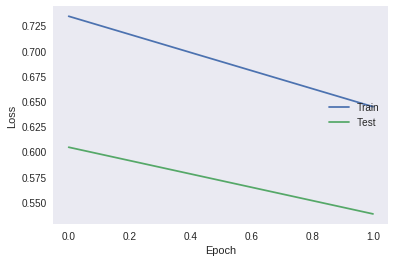

In [105]:
plt.figure()
plt.plot(training_history.history["loss"], label="Train")
plt.plot(training_history.history["val_loss"], label="Test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="center right")

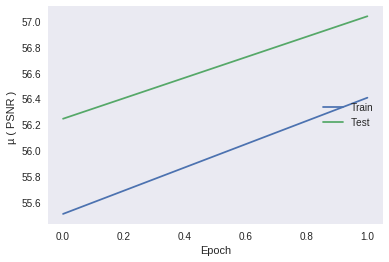

In [106]:
plt.figure()
plt.plot(training_history.history["mean_PSNR"], label="Train")
plt.plot(training_history.history["val_mean_PSNR"], label="Test")
plt.xlabel("Epoch")
plt.ylabel("µ ( PSNR ) ")
plt.legend(loc="center right")

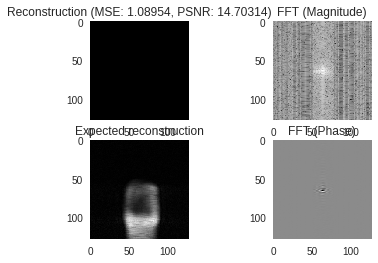

In [107]:
# Predict on a test batch

# batch = next(iter(test_dataset))

x, y = first_test_batch
x, y = x.numpy(), y.numpy()
y_pred = model.predict(x)

# Inspect output

for i in range(len(x)):

    fft_mag = x[i, ..., 0]
    fft_ang = x[i, ..., 1]
    reconstruction = y_pred[i, ..., 0]
    image = y[i, ..., 0]

    MSE = utils.signal_processing.mean_square_error(reconstruction, image)
    PSNR = utils.signal_processing.PSNR(reconstruction, image, max_value=max(image.max(), reconstruction.max()))

    plt.subplot(2, 2, 1)
    plt.title('Reconstruction (MSE: {:0.5f}, PSNR: {:0.5f})'.format(MSE, PSNR))
    utils.plot.imshowgray(reconstruction)

    plt.subplot(2, 2, 2)
    plt.title('FFT (Magnitude)')
    utils.plot.imshowfft(fft_mag)

    plt.subplot(2, 2, 3)
    plt.title('Expected reconstruction')
    utils.plot.imshowgray(image)

    plt.subplot(2, 2, 4)
    plt.title('FFT (Phase)')
    utils.plot.imshowgray(fft_ang)

    plt.show()
    break


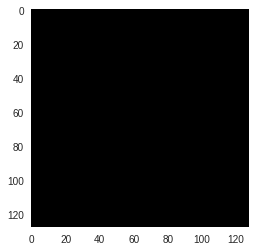

In [108]:
plt.imshow(y_pred[0].squeeze(), cmap='gray')

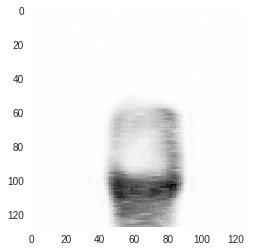

In [109]:
plt.imshow(y[0].squeeze())